In [ ]:
import numpy as np
import pandas as pd
from sklearn.neural_network import MLPClassifier
import optuna
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.metrics import classification_report, accuracy_score, roc_curve, auc, precision_recall_curve, confusion_matrix, roc_auc_score, RocCurveDisplay, PrecisionRecallDisplay
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import shap

In [41]:
df = pd.read_csv(r"C:\Users\Robyi\Documents\Data Science Dataset\diabetes.csv")
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [42]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [62]:
x = df.drop(columns=['Outcome'])
y = df['Outcome']

In [63]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.35, random_state=42, stratify=y)

In [64]:
pipeline_random = Pipeline([
    ('scaler', StandardScaler()),
    ('mlp',MLPClassifier(random_state=42, max_iter=100))
])

In [65]:
param_dist = {
    "mlp__hidden_layer_sizes": [(50,), (100,), (50, 50), (100, 50)],
    "mlp__activation": ["relu", "tanh"],
    "mlp__solver": ["adam", "sgd"],
    "mlp__alpha": [0.0001, 0.001, 0.01],
    "mlp__learning_rate": ["constant", "adaptive"],
}


random_search = RandomizedSearchCV(pipeline_random, param_dist, cv=5, n_jobs=-1, verbose=1)
random_search.fit(x_train, y_train)

print("Best parameters (RandomizedSearchCV):", random_search.best_params_)
best_model_random = random_search.best_estimator_

Fitting 5 folds for each of 10 candidates, totalling 50 fits


Best parameters (RandomizedSearchCV): {'mlp__solver': 'adam', 'mlp__learning_rate': 'adaptive', 'mlp__hidden_layer_sizes': (50,), 'mlp__alpha': 0.0001, 'mlp__activation': 'tanh'}


c:\Users\Robyi\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


In [66]:
y_pred_random = best_model_random.predict(x_test)
acc_random = accuracy_score(y_test, y_pred_random)
print("Test Accuracy (RandomizedSearchCV):", acc_random)

Test Accuracy (RandomizedSearchCV): 0.7509293680297398


In [67]:
def objective(trial):
    hidden_layer_sizes = tuple(trial.suggest_categorical("hidden_layer_sizes", [(50,), (100,), (50, 50), (100, 50)]))
    activation = trial.suggest_categorical("activation", ["relu", "tanh"])
    solver = trial.suggest_categorical("solver", ["adam", "sgd"])
    alpha = trial.suggest_float("alpha", 1e-4, 1e-2, log=True)
    learning_rate = trial.suggest_categorical("learning_rate", ["constant", "adaptive"])

    pipeline_bayes = Pipeline([
        ('scaler',StandardScaler()),
        ('mlp',MLPClassifier(random_state=42, max_iter=100, hidden_layer_sizes=hidden_layer_sizes, activation=activation, solver=solver,
                             alpha=alpha, learning_rate=learning_rate))
    ])
    pipeline_bayes.fit(x_train, y_train)
    y_pred = pipeline_bayes.predict(x_test)
    return accuracy_score(y_test, y_pred)

In [68]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=30, n_jobs=-1)

[I 2025-02-14 05:03:53,596] A new study created in memory with name: no-name-de031347-9fd8-4092-ba70-c58f57f6c8da
c:\Users\Robyi\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
c:\Users\Robyi\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
c:\Users\Robyi\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.
  warnings.warn(

In [72]:
print("Best parameters (Optuna):", study.best_params)
best_param=study.best_params
best_model = Pipeline([
    ('scaler',StandardScaler()),
    ('mlp',MLPClassifier(**best_param, max_iter=100, random_state=42))
])
best_model.fit(x_train, y_train)

Best parameters (Optuna): {'hidden_layer_sizes': (100, 50), 'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.0002158806839331049, 'learning_rate': 'constant'}


c:\Users\Robyi\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


Pipeline(steps=[('scaler', StandardScaler()),
                ('mlp',
                 MLPClassifier(activation='tanh', alpha=0.0002158806839331049,
                               hidden_layer_sizes=(100, 50), max_iter=100,
                               random_state=42, solver='sgd'))])

In [ ]:
y_pred = best_model.predict(x_test)
print(y_pred)

In [ ]:
proba = best_model.predict_proba(x_test)
print(proba)

In [ ]:
prediksi = pd.read_csv(r"C:\Users\Robyi\Documents\Data Science Dataset\diabetespredict.csv")
prediksi.head()

In [ ]:
y_prediksi = best_model.predict(prediksi)
probabilitas_prediksi = best_model.predict_proba(prediksi)
print(y_prediksi)
print(probabilitas_prediksi)

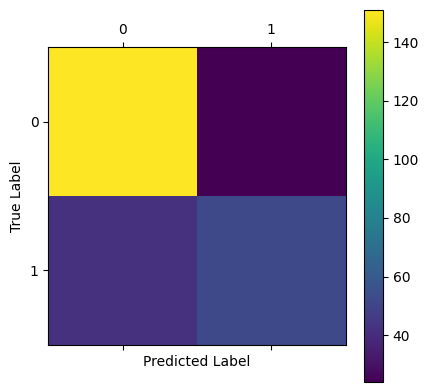

In [74]:
matrix = confusion_matrix(y_test, y_pred)

plt.matshow(matrix)
plt.colorbar()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

In [75]:
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.7546468401486989

Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.86      0.82       175
           1       0.68      0.55      0.61        94

    accuracy                           0.75       269
   macro avg       0.73      0.71      0.72       269
weighted avg       0.75      0.75      0.75       269



Text(113.9222222222222, 0.5, 'true value')

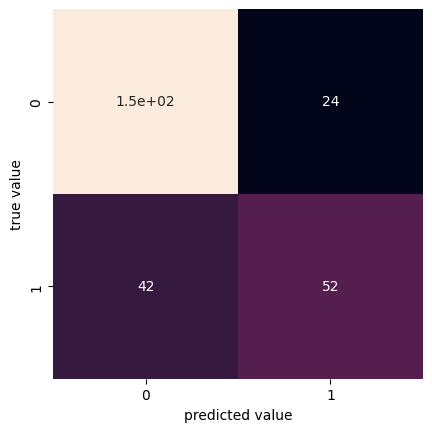

In [76]:
sns.heatmap(matrix, square  =True, annot = True, cbar = False)
plt.xlabel('predicted value')
plt.ylabel('true value')

In [77]:
cv_scores = cross_val_score(best_model, x_train, y_train, cv=5, scoring='accuracy')
print("Cross-Validation Scores:", cv_scores)
print("Mean CV Accuracy:", np.mean(cv_scores))

c:\Users\Robyi\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Robyi\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Robyi\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Robyi\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the opti

Cross-Validation Scores: [0.76       0.75       0.81       0.8        0.76767677]
Mean CV Accuracy: 0.7775353535353535


c:\Users\Robyi\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


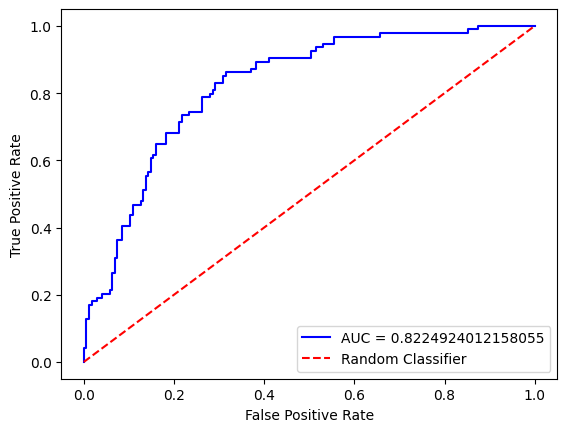

In [78]:
prob_estimate = best_model.predict_proba(x_test)

fpr, tpr, threshhold = roc_curve(y_test, prob_estimate[:,1])
nilai_auc = auc(fpr,tpr)

plt.plot(fpr, tpr,'b',label = f'AUC = {nilai_auc}')
plt.plot([0,1],[0,1], 'r--', label='Random Classifier')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

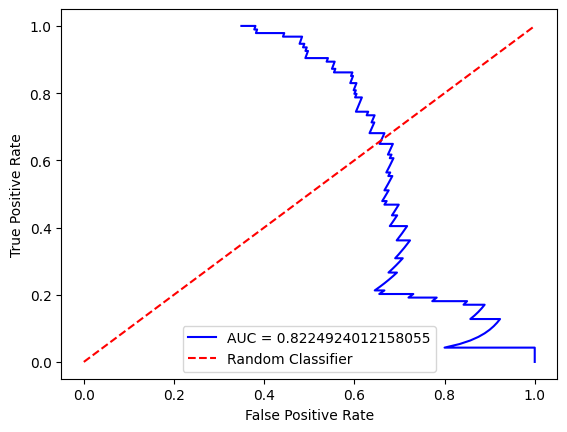

In [79]:
precision, recall, _ = precision_recall_curve(y_test, prob_estimate[:,1])
pr_auc = auc(recall,precision)

plt.plot(precision, recall,'b',label = f'AUC = {nilai_auc}')
plt.plot([0,1],[0,1], 'r--', label='Random Classifier')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

C:\Users\Robyi\AppData\Local\Temp\ipykernel_12764\61633017.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feature_importance, y=feature_names, orient="h", palette="viridis")


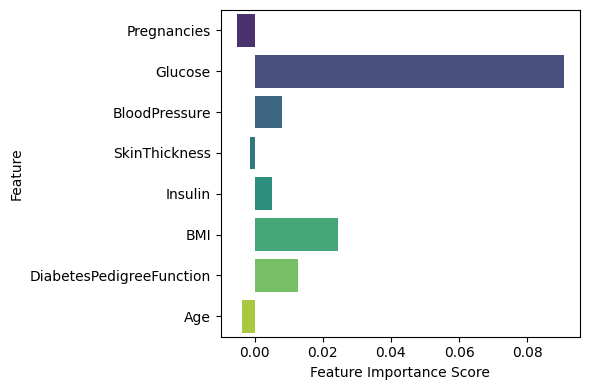

In [80]:
perm_importance = permutation_importance(best_model, x_test, y_test, scoring="accuracy")
feature_importance = perm_importance.importances_mean

feature_names = x_train.columns

plt.figure(figsize=(6, 4))
sns.barplot(x=feature_importance, y=feature_names, orient="h", palette="viridis")
plt.xlabel("Feature Importance Score")
plt.ylabel("Feature")
plt.tight_layout()

In [81]:
explainer = shap.Explainer(best_model.predict, x_train)
shap_values = explainer(x_test)

ExactExplainer explainer: 270it [01:31,  2.73it/s]                         


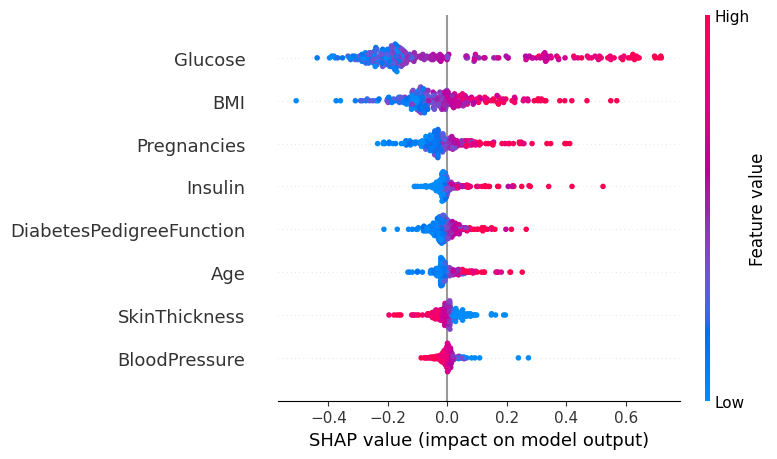

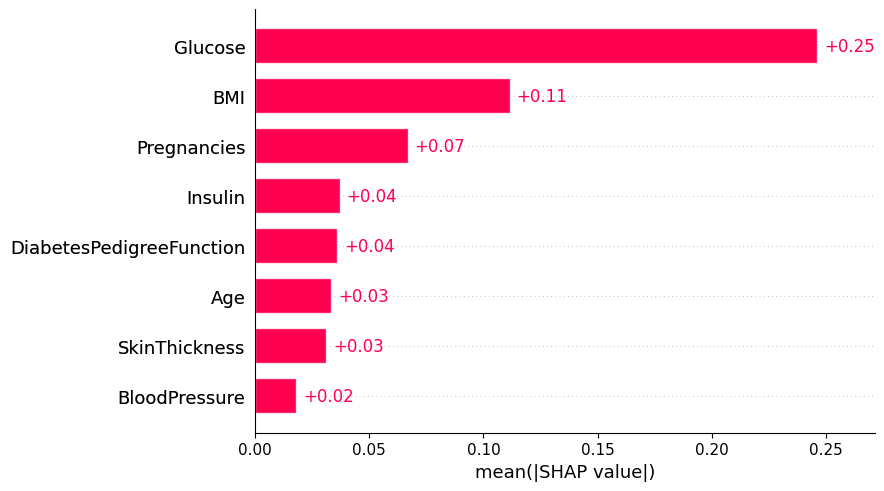

In [82]:
shap.summary_plot(shap_values, x_test, feature_names=x_train.columns)
shap.plots.bar(shap_values)